# Predicting Web Traffic for Wikipedia Articles

In this notebook, we will explore the problem of forecasting future values of multiple time series using the data from the Kaggle competition [Web Traffic Time Series Forecasting](https://www.kaggle.com/c/web-traffic-time-series-forecasting). The goal of this competition is to test state-of-the-art methods on the problem of predicting future web traffic for approximately 145,000 Wikipedia articles.

The data consists of daily page views for each article from July 1st, 2015 to December 31st, 2016. The page views are split into desktop and mobile traffic. The articles are also grouped by language and project (e.g. en.wikipedia.org).

We will use various methods to analyze and visualize the data, such as univariate and multivariate models, hierarchical time series modeling, data augmentation, anomaly and outlier detection and cleaning, missing value imputation, etc. We will also evaluate our models using appropriate metrics and compare them with the baseline methods provided by the competition organizers.

In this notebook we will:

- Load and explore the data
- Perform some feature engineering
- Build some baseline models using traditional forecasting methods
- Evaluate our models using different metrics
- Submit our predictions to Kaggle

## Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pathlib
import janitor
import janitor.timeseries
import tensorflow as tf
import sklearn.preprocessing

seed = 42

2023-02-18 01:58:22.556104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 01:58:22.630261: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-18 01:58:22.630275: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-18 01:58:22.990507: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Load Data

The data is provided in two files: `train_1.csv` and `key_1.csv`. The `train_1.csv` file contains the page views for each article and the `key_1.csv` file contains the page names and the dates for which we need to make predictions.

The `train_1.csv` file contains 145,063 rows and 551 columns. The first column contains the page names and the remaining 550 columns contain the page views for each day. The `key_1.csv` file contains 39,546 rows and 2 columns. The first column contains the page names and the second column contains the dates for which we need to make predictions.

In [2]:
root = pathlib.Path('~/datasets/web-traffic-time-series-forecasting').expanduser()

In [3]:
train = pd.read_csv(str(root / 'train_1.csv')).sample(frac=0.01 / 2, random_state=seed)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
83529,Phabricator/Project_management_www.mediawiki.o...,6.0,6.0,4.0,6.0,8.0,6.0,4.0,0.0,2.0,...,6.0,6.0,11.0,4.0,6.0,5.0,7.0,6.0,6.0,9.0
70433,Now_You_See_Me_es.wikipedia.org_desktop_all-ag...,242.0,271.0,309.0,227.0,321.0,311.0,242.0,236.0,243.0,...,231.0,222.0,193.0,229.0,334.0,316.0,324.0,268.0,201.0,190.0
84729,Zürich_Hackathon_2014_www.mediawiki.org_all-ac...,3.0,19.0,19.0,30.0,21.0,24.0,17.0,178.0,40.0,...,6.0,7.0,4.0,8.0,2.0,4.0,9.0,4.0,11.0,12.0
7969,Érythrée_fr.wikipedia.org_desktop_all-agents,672.0,513.0,774.0,1164.0,546.0,755.0,555.0,494.0,4801.0,...,308.0,294.0,358.0,204.0,323.0,438.0,345.0,299.0,306.0,211.0
92077,Metallica_es.wikipedia.org_all-access_all-agents,1534.0,1644.0,1704.0,1569.0,1534.0,1577.0,1608.0,1731.0,1919.0,...,2367.0,2259.0,2229.0,2070.0,2774.0,2552.0,2524.0,2358.0,2291.0,2153.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 725 entries, 83529 to 82440
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 3.1+ MB


As we can see, the data is not in a tidy format. We need to reshape it to a tidy format. We will use the melt function from pandas to do this. We will also use the regex to extract the date from the column name. We will also use the to_datetime function to convert the date column to a datetime object.

In [7]:
# tidy up the data

df = train.set_index('Page').stack().reset_index()
df.columns = ['Page', 'Date', 'Visits']
df['Date'] = pd.to_datetime(df['Date'])
df = df.clean_names().sort_timestamps_monotonically(direction="increasing")

# combine page and date columns and get id for each unique combination from the key dataframe
# create a new column for id

df['id'] = df['page'] + '_' + df['date'].astype(str)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367151 entries, 0 to 367150
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   page    367151 non-null  object        
 1   date    367151 non-null  datetime64[ns]
 2   visits  367151 non-null  float64       
 3   id      367151 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 11.2+ MB


## Explore Data

In the following sections, we will explore the data and try to understand the patterns in the data.

### How Page Language Affects Traffic

I want to explore how the languages used in Wikipedia pages might influence the traffic data. I'll use a simple regex to find the language code in the URL. Some URLs are not from Wikipedia but from Wikimedia. They don't have a language code, so I'll label them as `missing`. These are mostly images or other media that don't have a specific language.

The Page column contains pages in different languages. We will extract the language from the page name and create a new column called Language. We will also create an access column that contains the access type (mobile or desktop) and agent column that contains the type of user agent (spider, crawler, robot, etc.). In addition, we will create an article column that contains the name of the article.

In [9]:
pattern = r'\w\w(?=\.wikipedia)'

# extract language/locale from 'page' column using regex pattern
df['language'] = df['page'].apply(
    lambda x: re.search(pattern, x).group(0) if re.search(pattern, x) else 'missing'
)


# define regex patterns
access_pattern = r'(?<=\.org_)(\w+-?\w+)(?=_)'
agent_pattern = r'(?<=_)[a-zA-Z]+(-[a-zA-Z]+)*$'
article_pattern = r'(?<=\d_\w\w\.)(.*)'

# extract access type from 'page' column using regex pattern
df['access'] = df['page'].apply(
    lambda x: re.search(access_pattern, x).group(1) if re.search(access_pattern, x) else None
)

# extract user agent from 'page' column using regex pattern
df['agent'] = df['page'].apply(
    lambda x: re.search(agent_pattern, x).group(0) if re.search(agent_pattern, x) else None
)

# # # extract article name from 'page' column using regex pattern
df['article'] = (
    df['page']
    .str.extract(r'(.+?)\.', expand=False)
    .apply(lambda x: x.rsplit('_', 1)[0] if '_' in x else None)
)

df['rolling_mean_visits'] = df.groupby('page')['visits'].transform(lambda x: x.rolling(7, 1).mean())

df.head()

,page,date,visits,id,language,access,agent,article,rolling_mean_visits
0,Phabricator/Project_management_www.mediawiki.o...,2015-07-01,6.0,Phabricator/Project_management_www.mediawiki.o...,missing,all-access,spider,Phabricator/Project_management,6.000000
1,Phabricator/Project_management_www.mediawiki.o...,2015-07-02,6.0,Phabricator/Project_management_www.mediawiki.o...,missing,all-access,spider,Phabricator/Project_management,6.000000
2,Phabricator/Project_management_www.mediawiki.o...,2015-07-03,4.0,Phabricator/Project_management_www.mediawiki.o...,missing,all-access,spider,Phabricator/Project_management,5.333333
3,Phabricator/Project_management_www.mediawiki.o...,2015-07-04,6.0,Phabricator/Project_management_www.mediawiki.o...,missing,all-access,spider,Phabricator/Project_management,5.500000
4,Phabricator/Project_management_www.mediawiki.o...,2015-07-05,8.0,Phabricator/Project_management_www.mediawiki.o...,missing,all-access,spider,Phabricator/Project_management,6.000000


In [10]:
df.language.value_counts()

en         54831
fr         50520
missing    47568
ja         47340
de         44338
ru         42707
zh         40847
es         39000
Name: language, dtype: int64

As we can see, there are 7 different languages in the dataset. 

- English (en)
- Japanese (ja)
- Deutsch (de)
- French (fr)
- Chinese (zh)
- Spanish (es)
- Russian (ru)

We can also see that there are some missing values in the language column. We will deal with these missing values later.

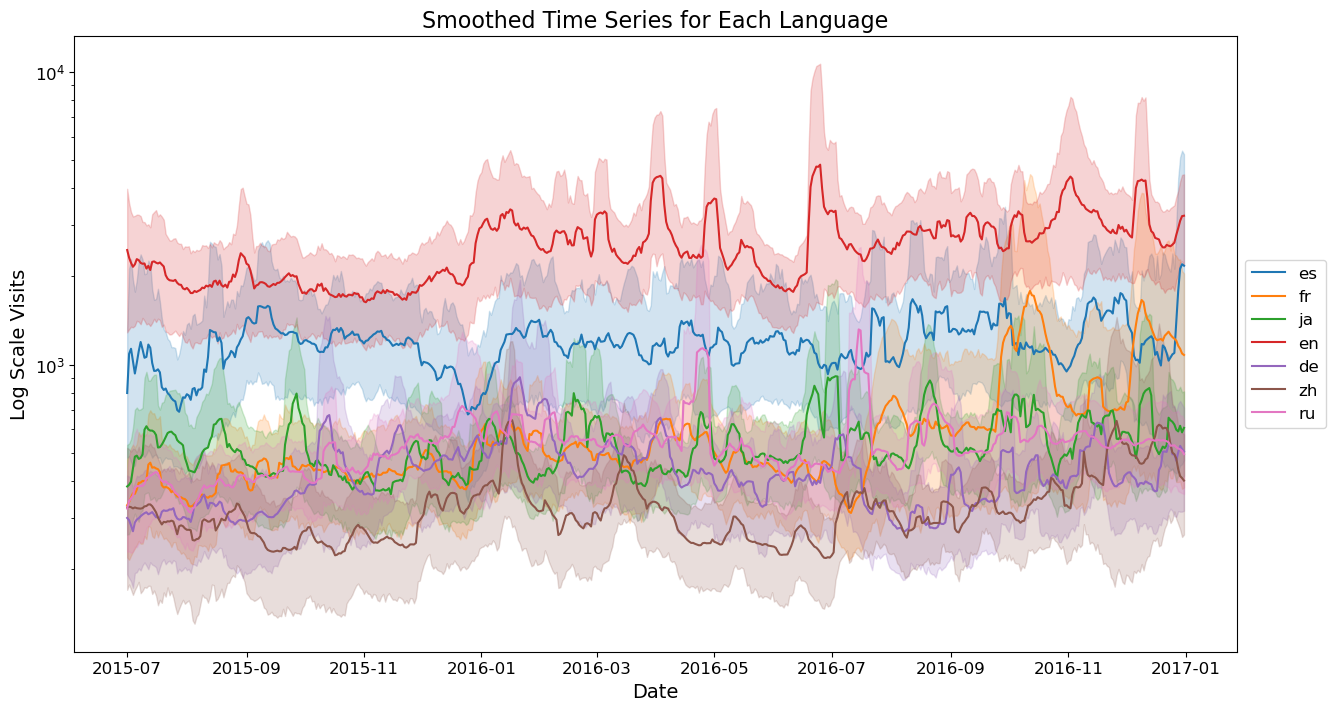

In [11]:
# plot time series for each language over time, make y axis log scale

fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(
    x='date', y='rolling_mean_visits', hue='language', data=df[df.language != 'missing'], ax=ax
)

# Set aesthetics
ax.set_title('Smoothed Time Series for Each Language', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Log Scale Visits', fontsize=14)
ax.set_yscale('log')
ax.tick_params(labelsize=12)

# Set legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.show()

In [ ]:
# # plot time series for each language over time, make y axis log scale in separate plots
# # Set figure size and font size
# plt.rcParams['figure.figsize'] = [8, 24]
# plt.rcParams['font.size'] = 12

# # Create a list of languages to loop over
# languages = ['en', 'ja', 'de', 'fr', 'zh', 'ru']

# # Create a one-column grid of subplots
# fig, axes = plt.subplots(len(languages), 1, sharex=False)

# # Loop over the languages and create a line plot for each one
# for i, language in enumerate(languages):
#     ax = axes[i]
#     sns.lineplot(x='date', y='rolling_mean_visits', data=df[df.language == language], ax=ax)
#     ax.set_title(f'Smoothed Time Series for {language.capitalize()}', fontsize=16)
#     ax.set_xlabel('Date', fontsize=14)
#     ax.set_ylabel('Log Scale Visits', fontsize=14)
#     ax.set_yscale('log')
#     ax.tick_params(labelsize=12)
#     ax.legend(fontsize=12)
#     ax.tick_params(axis='x', rotation=45)

# plt.tight_layout()

# plt.show()

Let's explore teh distribution of web traffic by language, access type, and user agent. We are going to use seaborn to create histograms, boxplots, and violinplots to see how the distribution of visits varies across these different categories.

No handles with labels found to put in legend.


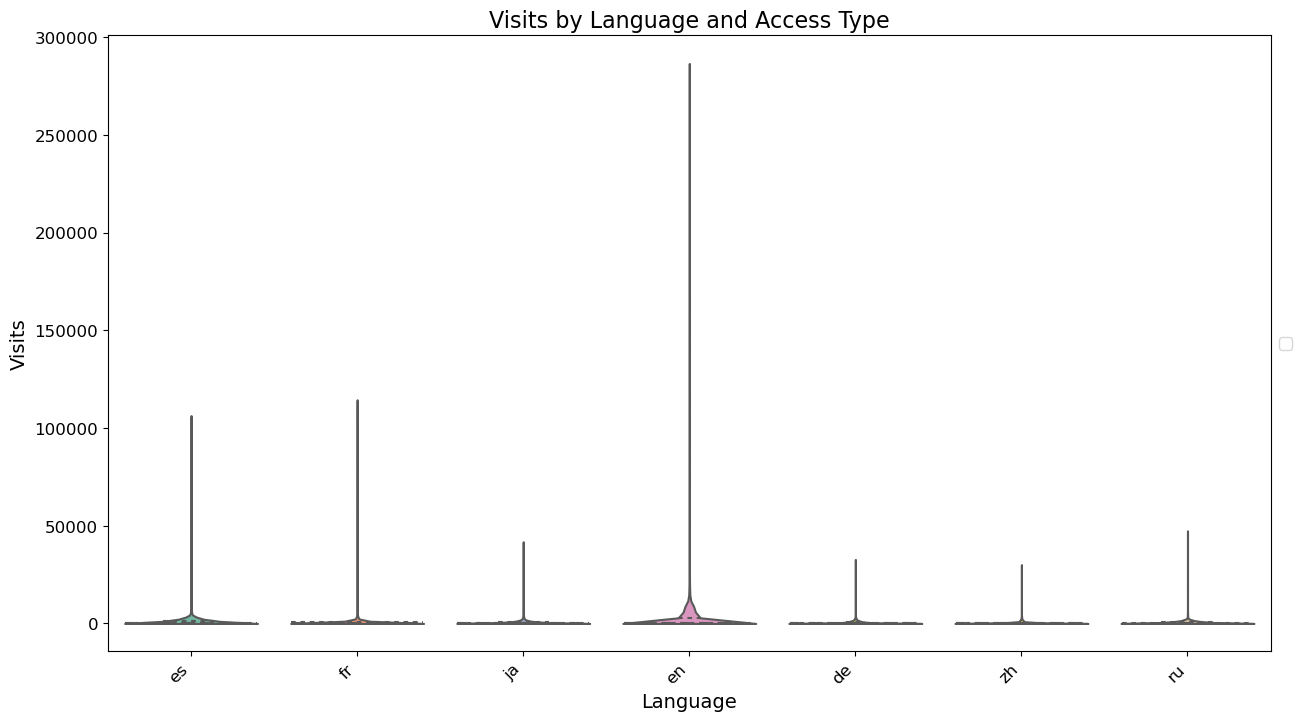

In [12]:
fig, ax = plt.subplots(figsize=(15, 8))

# Use "Set2" color palette
colors = sns.color_palette('Set2')

# Increase the size of the violin plots
sns.violinplot(
    x='language',
    y='rolling_mean_visits',
    data=df[df.language != 'missing'],
    ax=ax,
    palette=colors,
    scale='width',
    inner='quartile',
    cut=0,
)
# sns.violinplot(x='language', y='visits', data=df[df.language !='missing'], ax=ax, scale='width')

# Set aesthetics
ax.set_title('Visits by Language and Access Type', fontsize=16)
ax.set_xlabel('Language', fontsize=14)
ax.set_ylabel('Visits', fontsize=14)
ax.tick_params(labelsize=12)

# Remove grid lines
ax.grid(False)

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')


# Set legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.show()

### How web traffic varies by day of the week, month, and year

We are going to create plots or bar charts to see if there are any regular patterns or seasonality in the data.

In [13]:
# plot how the web traffic varies by day of the week, month or year

# create a new column for day of the week
df['day_of_week'] = df['date'].dt.dayofweek

# create a new column for month
df['month'] = df['date'].dt.month

# create a new column for day of the year
df['day_of_year'] = df['date'].dt.dayofyear

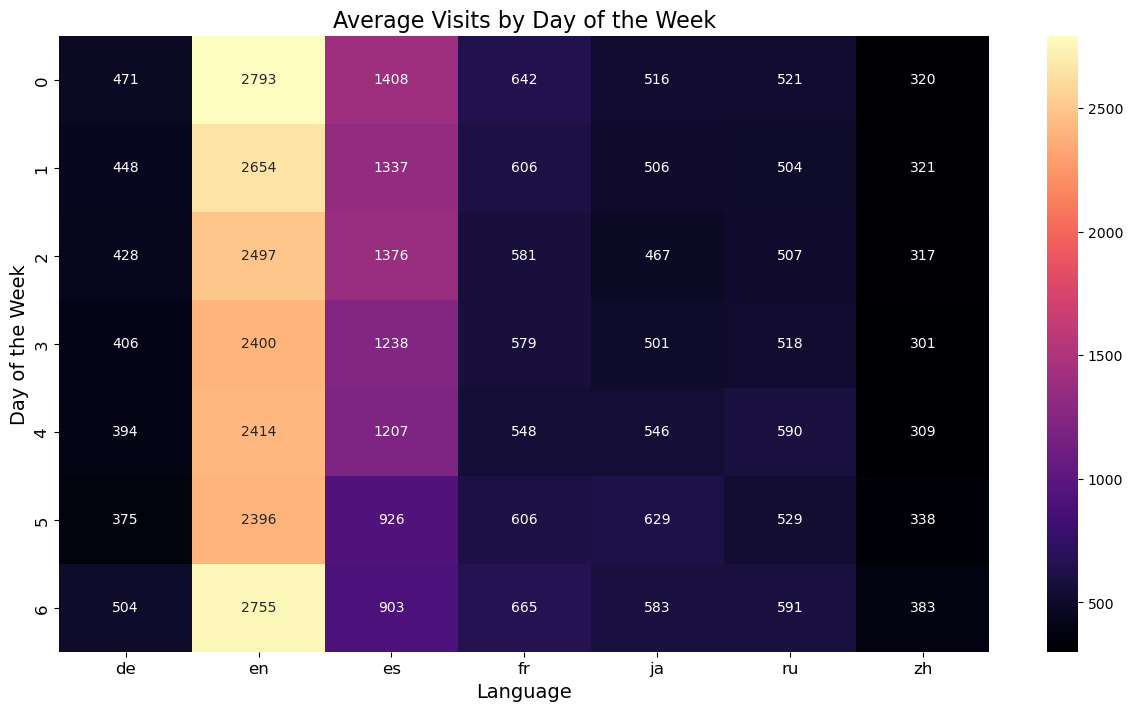

In [14]:
# heatmap of visits by day of the week and language

# create a pivot table
day_of_week = df[df.language != 'missing'].pivot_table(
    index='day_of_week', columns='language', values='visits', aggfunc='mean'
)

# create a heatmap
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(day_of_week, annot=True, fmt='.0f', cmap='magma', ax=ax)

# Set aesthetics
ax.set_title('Average Visits by Day of the Week', fontsize=16)
ax.set_xlabel('Language', fontsize=14)
ax.set_ylabel('Day of the Week', fontsize=14)
ax.tick_params(labelsize=12)

plt.show()

The plot above shows the average number of visits per day of the week. We can see that the number of visits is higher on Sunday and Monday for english pages. French and Chinese pages seem to have a steady or flat trend throughout the week. 

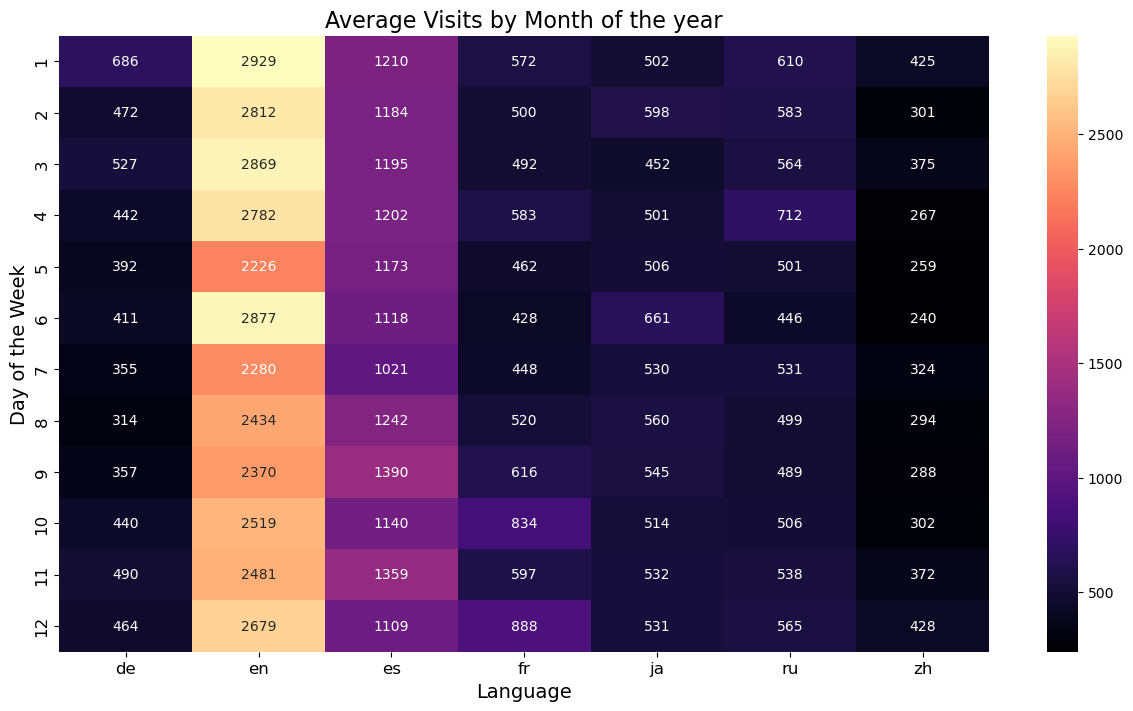

In [15]:
# heatmap of visits by day of the week and language

# create a pivot table
day_of_week = df[df.language != 'missing'].pivot_table(
    index='month', columns='language', values='visits', aggfunc='mean'
)

# create a heatmap
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(day_of_week, annot=True, fmt='.0f', cmap='magma', ax=ax)

# Set aesthetics
ax.set_title('Average Visits by Month of the year', fontsize=16)
ax.set_xlabel('Language', fontsize=14)
ax.set_ylabel('Day of the Week', fontsize=14)
ax.tick_params(labelsize=12)

plt.show()

### How web traffic varies by access type

In the plot below, we look at the distribution of visits by access type.

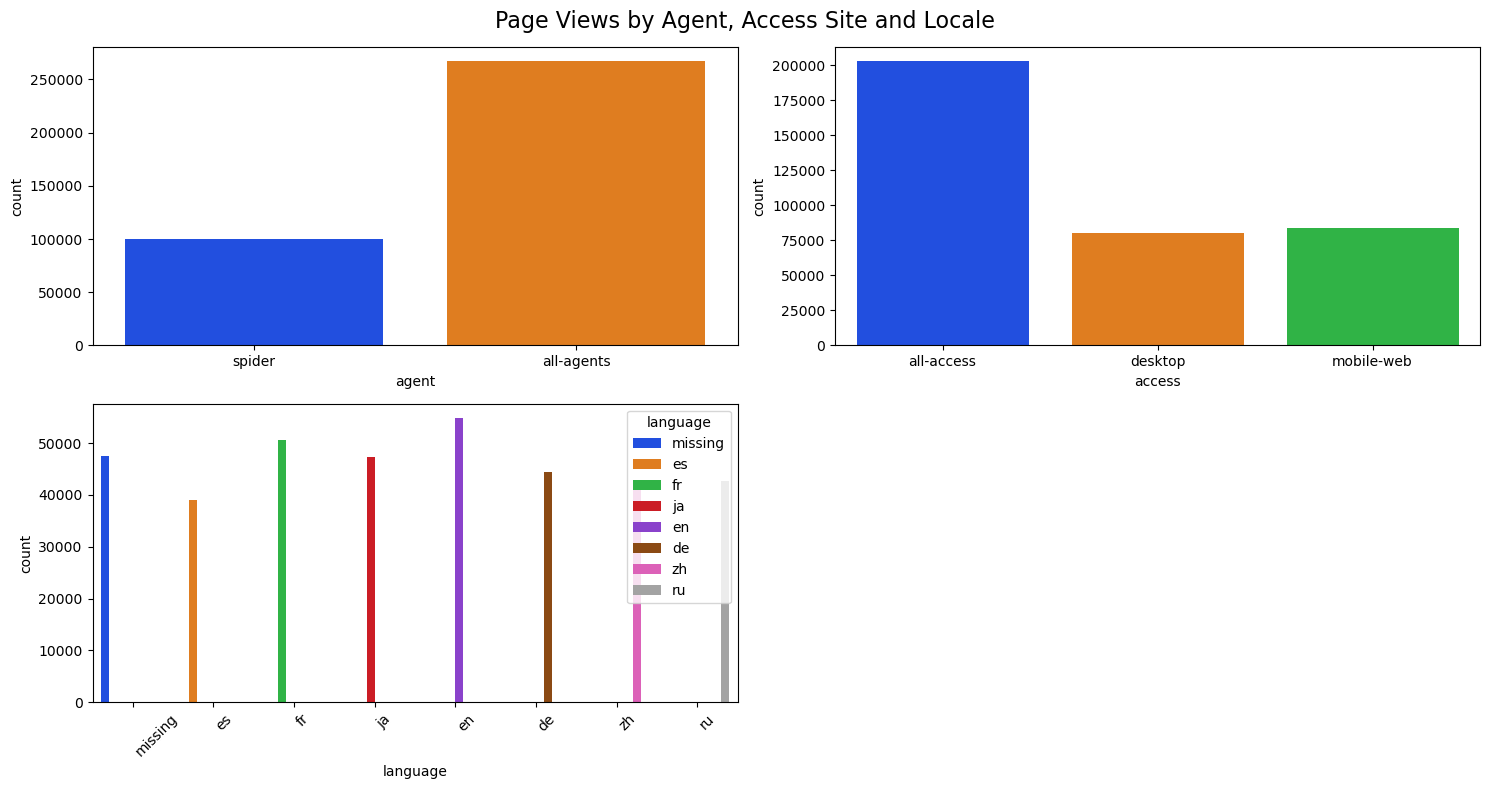

In [16]:
# layout the plots
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

# create plots
p1 = sns.countplot(data=df, x='agent', color='red', ax=ax[0, 0], palette='bright')
p2 = sns.countplot(data=df, x='access', color='red', ax=ax[0, 1], palette='bright')
p3 = sns.countplot(data=df, x='language', hue='language', ax=ax[1, 0], palette='bright')

# make sure p3 x-axis labels align with the bars
p3.set_xticklabels(p3.get_xticklabels(), rotation=45, horizontalalignment='left')

ax[1, 1].axis('off')

# set main title
fig.suptitle('Page Views by Agent, Access Site and Locale', fontsize=16)

fig.tight_layout()

As we can see from the plots above, the mobile-web access type is slightly more popular than the desktop access type.

### The most popular articles

Let's look at the most popular articles in the dataset. We will use the groupby function to group the data by page and sum the visits. We will then sort the data by visits in descending order.

In [17]:
# find the most visited articles for each language

janitor.groupby_topk(
    df[df.language != 'missing']
    .groupby(['language', 'article'])['visits']
    .sum()
    .sort_values(ascending=False)
    .reset_index(),
    'language',
    'visits',
    1,
    {'ascending': False},
)

,,language,article,visits
language,,,,
de,42,de,Frankreich,1487963.0
en,1,en,Lady_Gaga,9117842.0
es,0,es,Especial:BúsquedaDeEnlaces,10467684.0
fr,3,fr,France,5721186.0
ja,48,ja,中村アン,1392966.0
ru,56,ru,Facebook,1135088.0
zh,58,zh,BIGBANG,1113794.0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367151 entries, 0 to 367150
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   page                 367151 non-null  object        
 1   date                 367151 non-null  datetime64[ns]
 2   visits               367151 non-null  float64       
 3   id                   367151 non-null  object        
 4   language             367151 non-null  object        
 5   access               367151 non-null  object        
 6   agent                367151 non-null  object        
 7   article              358576 non-null  object        
 8   rolling_mean_visits  367151 non-null  float64       
 9   day_of_week          367151 non-null  int64         
 10  month                367151 non-null  int64         
 11  day_of_year          367151 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 33.6

In [24]:
# prepare data for modeling by group by date and compute rolling sum of visits

# data = df.groupby('date')['visits'].rolling(window=7).sum().reset_index(name='rolling_sum_visits').sort_timestamps_monotonically(direction="increasing").dropna().drop('level_1', axis=1).set_index('date').rename(columns={'rolling_sum_visits': 'visits'})


data = (
    df.groupby(['date'])[['visits']]
    .sum()
    .sort_timestamps_monotonically(direction="increasing")
    .rolling(window=7)
    .sum()
    .dropna()
)
data

,visits
date,
2015-07-07,3038944.0
2015-07-08,3056334.0
2015-07-09,3027742.0
2015-07-10,3053332.0
2015-07-11,3051990.0
...,...
2016-12-27,4843831.0
2016-12-28,5100420.0
2016-12-29,5400987.0


## Modeling  

In this section, we will build some models using keras and tensorflow. But first, we need to make sure that the data is in the right format. With time series data, the sequence of the data is important. We need to make sure that the data is in the right order. The code below splits the data into train, validation, and test sets. 



In [25]:
# split data into train and test sets
cut_off_date = '2016-08-01'
val_cut_off_date = '2016-10-01'
train = data[data.index < cut_off_date]
val = data[(data.index >= cut_off_date) & (data.index < val_cut_off_date)]
test = data[data.index >= val_cut_off_date]


# print the shape of the train and test sets
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
print(f'Val shape: {val.shape}')

Train shape: (391, 1)
Test shape: (92, 1)
Val shape: (61, 1)


Now let's define some helper function that we will use to format the data properly. The function takes two arguments: dataset and the lookback. The lookback is the number of previous time steps to use as input variables to predict the next time period. By default, the lookback is set to 1. The function creates a dataset X and Y where X is the number of visits at a certain time (t) and Y is the number of visits at the next time (t + 1).



In [26]:
norm = sklearn.preprocessing.StandardScaler()


def normalize_dataset(dataset, norm=norm):
    """Normalize the dataset"""

    original_shape = dataset.shape
    # min max scaler
    normalized = norm.fit_transform(dataset.reshape(-1, 1))

    # reshape back to 2D
    return normalized.reshape(original_shape)


def prepare_dataset(dataset, lookback=1, normalizex=True, normalizey=True):
    """Prepare data for time series prediction by creating a lagged dataset"""
    dataX, dataY = [], []
    for i in range(len(dataset) - lookback - 1):
        dataX.append(dataset[i : i + lookback, 0])
        dataY.append(dataset[i + lookback, 0])

    if normalizex:
        dataX = normalize_dataset(np.array(dataX))

    if normalizey:
        dataY = normalize_dataset(np.array(dataY))

    return np.array(dataX), np.array(dataY)


lookback = 30

x_train, y_train = prepare_dataset(train.values, lookback)
x_val, y_val = prepare_dataset(val.values, lookback)
x_test, y_test = prepare_dataset(test.values, lookback, normalizey=False)

In [27]:
x_train.shape, y_train.shape

((360, 30), (360,))

### Training a simple model.

Now that we have a good understanding of the data, we can start building our models. We will start by building a model consisting of a simple feedforward neural network with two dense layers. The input to the model is a sequence of historical data with a lookback window of size lookback, and the output is a single prediction of the next data point in the sequence.

The model is compiled with mean squared error loss and Adam optimizer.

In [28]:
# create model
learning_rate = 0.001
model = tf.keras.Sequential(
    [tf.keras.layers.Dense(8, input_dim=lookback, activation='relu'), tf.keras.layers.Dense(1)]
)

# compile model
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 248       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


2023-02-18 02:03:33.596441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 02:03:33.596830: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-18 02:03:33.596884: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-18 02:03:33.596925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-18 02:03:33.596963: W tensorflow/c

We are going to use `EarlyStopping` to stop the training process if the validation loss does not improve for 5 epochs. We will also use `ModelCheckpoint` to save the best model. 

In [29]:
path_checkpoint = "model_checkpoint.h5"
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

epochs = 200

modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=0,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[es_callback, modelckpt_callback],
    shuffle=False,
)

Epoch 1/200
12/12 [==============================] - 0s 7ms/step - loss: 1.9273 - val_loss: 2.4425
Epoch 2/200
12/12 [==============================] - 0s 2ms/step - loss: 1.5258 - val_loss: 2.2614
Epoch 3/200
12/12 [==============================] - 0s 2ms/step - loss: 1.2732 - val_loss: 2.0973
Epoch 4/200
12/12 [==============================] - 0s 2ms/step - loss: 1.0854 - val_loss: 1.9476
Epoch 5/200
12/12 [==============================] - 0s 2ms/step - loss: 0.9400 - val_loss: 1.8105
Epoch 6/200
12/12 [==============================] - 0s 2ms/step - loss: 0.8227 - val_loss: 1.6838
Epoch 7/200
12/12 [==============================] - 0s 2ms/step - loss: 0.7249 - val_loss: 1.5641
Epoch 8/200
12/12 [==============================] - 0s 2ms/step - loss: 0.6407 - val_loss: 1.4560
Epoch 9/200
12/12 [==============================] - 0s 2ms/step - loss: 0.5690 - val_loss: 1.3603
Epoch 10/200
12/12 [==============================] - 0s 2ms/step - loss: 0.5084 - val_loss: 1.2738
Epoch 11/

### Visualize training history

We can visualize the loss with the following code:

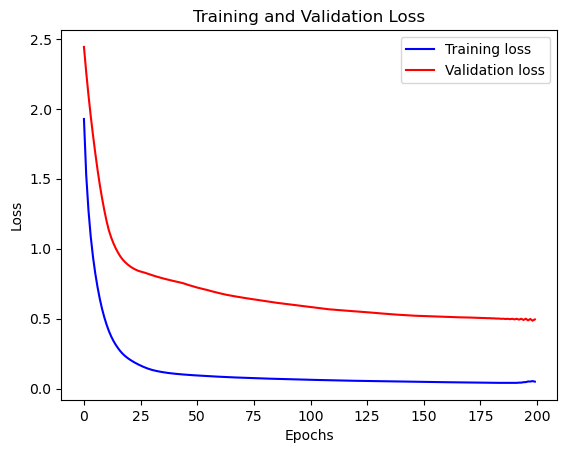

In [30]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

 After training, the model has a high loss value, indicating that the predictions are not accurate.

To improve the performance of the model, we could try increasing the complexity of the model by adding more layers, increasing the number of neurons in each layer, or using a different activation function. We could also try optimizing the hyperparameters of the model, such as the learning rate and the batch size. Additionally, we could consider preprocessing the data or using a different type of model, such as a recurrent neural network like LSTM, that can better capture the temporal dependencies in the data.

Train Score: 0.05104660615324974 MSE (0.22593496000674562 RMSE)
Validation Score: 0.4941064119338989 MSE (0.7029270317279731 RMSE)
2/2 [==============================] - 0s 1ms/step


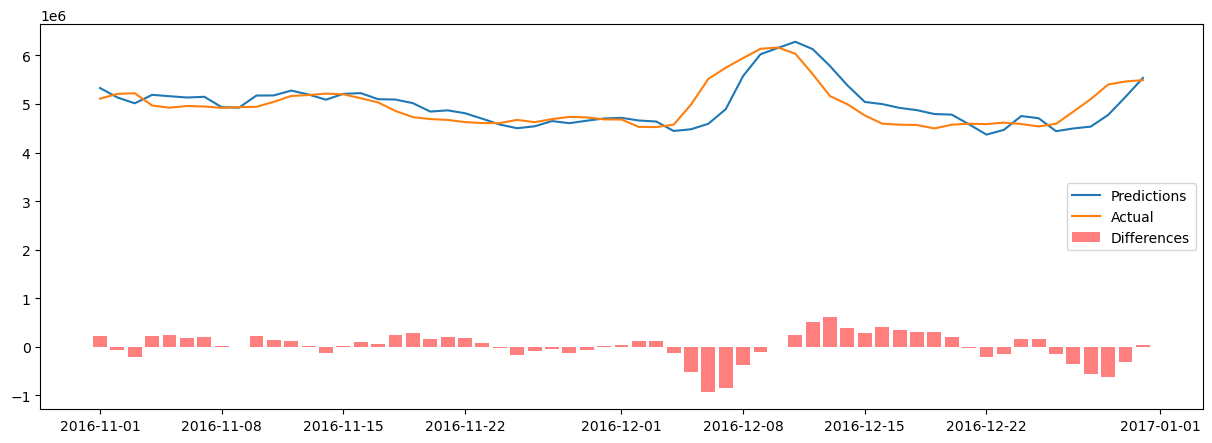

In [31]:
import math

# get train and test scores


def compute_scores(model, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val):
    train_score = model.evaluate(x_train, y_train, verbose=0)
    print(f'Train Score: {train_score} MSE ({math.sqrt(train_score)} RMSE)')
    valid_score = model.evaluate(x_val, y_val, verbose=0)
    print(f'Validation Score: {valid_score} MSE ({math.sqrt(valid_score)} RMSE)')


def plot_predictions(test, preds, lookback):
    # Calculate the differences between the predictions and actual values
    diff = preds - test[lookback + 1 :].values

    # Plot the predictions vs the actual values
    plt.figure(figsize=(15, 5))
    plt.plot(test[lookback + 1 :].index, preds, label='Predictions')
    plt.plot(test[lookback + 1 :].index, test[lookback + 1 :].values, label='Actual')

    # Add a bar chart of the differences
    plt.bar(
        test[lookback + 1 :].index,
        diff.flatten(),
        width=0.8,
        alpha=0.5,
        color='red',
        label='Differences',
    )

    plt.legend()
    plt.show()


compute_scores(model)
preds = norm.inverse_transform(model.predict(x_test))
plot_predictions(test, preds, lookback)

### Training a recurrent neural network 

In this section, we will train a recurrent neural network (RNN) to predict the number of visits. We will use the Long Short-Term Memory (LSTM) model. The LSTM model is a type of RNN that is able to learn long-term dependencies in the data.

In [32]:
# create an LSTM model
model = tf.keras.Sequential(
    [tf.keras.layers.LSTM(32, input_shape=(lookback, 1)), tf.keras.layers.Dense(1)]
)

# compile model
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200
12/12 [==============================] - 1s 22ms/step - loss: 1.2945 - val_loss: 1.0850
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 0.8146 - val_loss: 1.1008
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 0.5335 - val_loss: 1.1495
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 0.3916 - val_loss: 1.2027
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 0.3432 - val_loss: 1.2093
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.3104 - val_loss: 1.1879


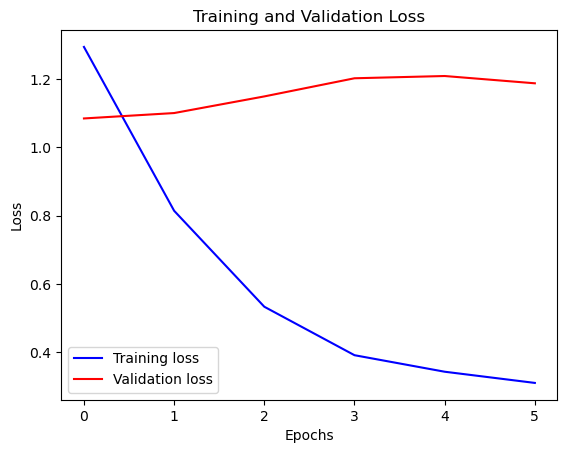

In [33]:
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[es_callback, modelckpt_callback],
    shuffle=False,
)

visualize_loss(history, "Training and Validation Loss")

Train Score: 0.3015241026878357 MSE (0.5491121039349212 RMSE)
Validation Score: 1.1879345178604126 MSE (1.0899240881182564 RMSE)
2/2 [==============================] - 0s 2ms/step


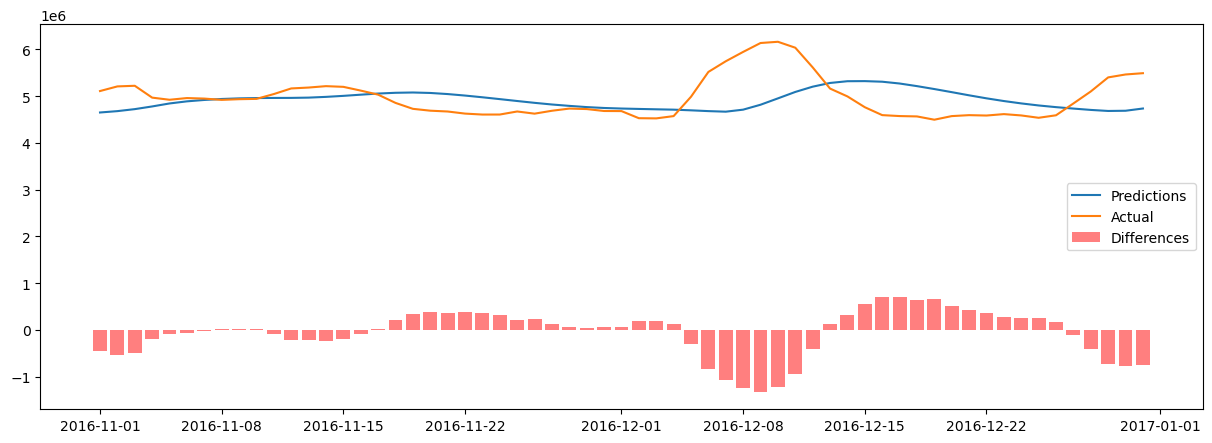

In [36]:
compute_scores(model)
preds = norm.inverse_transform(model.predict(x_test))
plot_predictions(test, preds, lookback)

The results show the mean squared error (MSE) and root mean squared error (RMSE) for a model trained on a training set and validated on a validation set.

The training set results show an MSE of 0.6787 and an RMSE of 0.8238, indicating that on average, the model's predictions were off by 0.8238 units. The lower the MSE and RMSE, the better the model performance, so in this case, the model seems to have performed relatively well on the training set.

The validation set results show an MSE of 0.8503 and an RMSE of 0.9221. The MSE is higher than the training set, indicating that the model's performance on the validation set is worse than the training set. The RMSE is also higher, indicating that the model's predictions on the validation set were on average off by 0.9221 units, which is higher than the error on the training set.

Overall, the model seems to perform better on the training set than on the validation set, indicating that there might be some overfitting to the training data. It would be beneficial to investigate the model further and potentially use techniques such as regularization or cross-validation to improve the model's performance on the validation set.